In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import gc
import yaml
import sys

# ==============================================================================
# 1. CARGA DE CONFIGURAÇÃO (YAML)
# ==============================================================================
def find_project_root(anchor_file="conf/config.yaml"):
    current_path = Path.cwd()
    for parent in [current_path] + list(current_path.parents):
        if (parent / anchor_file).exists(): return parent
    raise FileNotFoundError(f"Raiz do projeto não encontrada.")

try:
    BASE_DIR = find_project_root()
    print(f"📂 Raiz do Projeto: {BASE_DIR}")
except:
    BASE_DIR = Path("/Users/lucasborges/Downloads/TCC") # Fallback
    print(f"⚠️ Fallback: {BASE_DIR}")

with open(BASE_DIR / "conf/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Atalhos
P = {k: BASE_DIR / v for k, v in config['paths'].items()}
F = config['files']

# ==============================================================================
# 2. DEFINIÇÃO DE CAMINHOS DINÂMICOS
# ==============================================================================
print("Mapeando arquivos de avaliação...")

# Embeddings (Gerados no Notebook 6 e 7)
TRAIN_EMB_PATH = P['processed'] / F['track_embeddings']      # Z_train
NEW_EMB_PATH   = P['processed'] / F['new_track_embeddings']  # Z_new

# Metadados Completos (Para montar histórico e target)
# Se não estiver no F, usamos o nome padrão na pasta interim
TRACKS_COMPLETE_PATH = P['interim'] / "df_tracks_complete_v5.parquet"

# Parâmetros
CUTOFF_YEAR = 2015

# Validação
for path in [TRAIN_EMB_PATH, NEW_EMB_PATH, TRACKS_COMPLETE_PATH]:
    if not path.exists():
        print(f"⚠️ Aviso: Arquivo não encontrado: {path.name}")

# ==============================================================================
# 3. FUNÇÃO DE CARGA E NORMALIZAÇÃO
# ==============================================================================
def load_and_normalize(path, uri_col="track_uri", prefix="emb_mean_"):
    print(f"Carregando: {path.name}...")
    df = pd.read_parquet(path)
    
    # Identificar colunas de embedding automaticamente
    emb_cols = [c for c in df.columns if c.startswith(prefix)]
    
    # Extrair matriz numpy
    Z = df[emb_cols].to_numpy().astype("float32")
    uris = df[uri_col].to_numpy()
    
    # Normalização L2 (Vital para Cosseno ser equivalente a produto escalar)
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    norms[norms == 0] = 1e-10 # Evitar divisão por zero
    Z_norm = Z / norms
    
    # Criar mapa URI -> Índice da Matriz
    uri2idx = {u: i for i, u in enumerate(uris)}
    
    return Z_norm, uris, uri2idx

# ==============================================================================
# 4. EXECUÇÃO
# ==============================================================================

# 1. Carregar Treino (Histórico/Contexto)
# Representa o conhecimento "passado" do modelo
Z_train, uris_train, train_map = load_and_normalize(TRAIN_EMB_PATH)

# 2. Carregar Teste (Candidatos Cold-Start)
# Representa as músicas "futuras" projetadas via KNN + GNN
Z_new, uris_new, new_map = load_and_normalize(NEW_EMB_PATH)

# Sets para verificação rápida O(1)
train_uri_set = set(uris_train)
new_uri_set = set(uris_new)

print("\n" + "="*40)
print(f"Matriz Treino (Histórico): {Z_train.shape}")
print(f"Matriz Teste (Candidatos): {Z_new.shape}")
print("="*40)

📂 Raiz do Projeto: /Users/lucasborges/Downloads/TCC
Mapeando arquivos de avaliação...
Carregando: track_embeddings_mean.parquet...
Carregando: new_track_embeddings_mean.parquet...

Matriz Treino (Histórico): (324132, 64)
Matriz Teste (Candidatos): (62891, 64)


In [3]:
def prepare_playlists(tracks_path, cutoff_year):
    print("\nProcessando playlists e dividindo temporalmente...")
    df = pd.read_parquet(tracks_path)
    
    # Converter ano para numérico e tratar erros
    df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").fillna(0)
    
    # Filtros iniciais de validade (só músicas que temos embedding)
    # A música deve estar em (Treino) OU (Novo)
    # Mas para montar o histórico, só nos importa se está no Treino
    # Para montar o target, só nos importa se está no Novo
    
    # Split
    mask_hist = (df["release_year"] <= cutoff_year) & (df["track_uri"].isin(train_uri_set))
    mask_target = (df["release_year"] > cutoff_year) & (df["track_uri"].isin(new_uri_set))
    
    df_hist = df[mask_hist][["pid", "track_uri"]]
    df_target = df[mask_target][["pid", "track_uri"]]
    
    # Agrupar
    print("Agrupando Histórico...")
    hist_dict = df_hist.groupby("pid")["track_uri"].apply(list).to_dict()
    
    print("Agrupando Target (Ground Truth)...")
    target_dict = df_target.groupby("pid")["track_uri"].apply(set).to_dict() # Set é mais rápido para métricas
    
    return hist_dict, target_dict

hist_by_pid, target_by_pid = prepare_playlists(TRACKS_COMPLETE_PATH, CUTOFF_YEAR)

# Filtrar apenas playlists válidas (que têm passado E futuro)
valid_pids = [
    pid for pid in hist_by_pid 
    if pid in target_by_pid 
    and len(hist_by_pid[pid]) >= 5      # Mínimo 5 músicas antigas para formar gosto
    and len(target_by_pid[pid]) >= 1    # Pelo menos 1 música nova para testar
]

print(f"\nPlaylists Válidas para Avaliação: {len(valid_pids):,}")


Processando playlists e dividindo temporalmente...
Agrupando Histórico...
Agrupando Target (Ground Truth)...

Playlists Válidas para Avaliação: 54,155


In [4]:
class ColdStartEvaluator:
    def __init__(self, Z_train, train_map, Z_new, uris_new):
        self.Z_train = Z_train      # Matriz Embeddings Treino
        self.train_map = train_map  # Dict URI -> Index
        self.Z_new = Z_new          # Matriz Embeddings Novos (Candidatos)
        self.uris_new = uris_new    # Array de URIs novos para retorno
        
    def get_playlist_embedding(self, tracks_uris):
        """Calcula vetor da playlist (Média das músicas de treino)"""
        # Converte URIs para Indices
        indices = [self.train_map[u] for u in tracks_uris if u in self.train_map]
        
        if not indices:
            return None
            
        # Busca vetores e faz média
        vectors = self.Z_train[indices]
        p_vec = np.mean(vectors, axis=0)
        
        # Renormaliza para ficar na esfera unitária
        norm = np.linalg.norm(p_vec) + 1e-10
        return p_vec / norm

    def compute_metrics(self, pids_list, hist_dict, target_dict, k_list=[20, 50]):
        """
        Gera recomendações e calcula métricas em lote.
        """
        # 1. Montar Matriz de Playlists do Lote
        p_matrix = []
        valid_batch_pids = []
        
        for pid in pids_list:
            p_vec = self.get_playlist_embedding(hist_dict[pid])
            if p_vec is not None:
                p_matrix.append(p_vec)
                valid_batch_pids.append(pid)
        
        if not p_matrix:
            return []

        P = np.array(p_matrix) # Shape: [Batch_Size, Emb_Dim]
        
        # 2. Recomendação Vetorizada (Batch x Todos Candidatos)
        # Scores: [Batch_Size, N_Novas]
        # Multiplicação matricial massiva
        scores = P @ self.Z_new.T 
        
        results = []
        
        # 3. Extrair Top-K e Calcular Métricas por Playlist
        # Argpartition é mais rápido que sort total
        max_k = max(k_list)
        
        # Para cada playlist no batch
        for i, pid in enumerate(valid_batch_pids):
            row_scores = scores[i]
            true_items = target_dict[pid] # Set de URIs
            
            # Pegar indices dos top K maiores scores
            # Note: argpartition não ordena o top-k, então precisamos ordenar depois
            top_k_indices = np.argpartition(-row_scores, max_k)[:max_k]
            # Ordenar apenas os top k
            top_k_indices = top_k_indices[np.argsort(-row_scores[top_k_indices])]
            
            rec_uris = self.uris_new[top_k_indices]
            
            # Calcular métricas para cada K solicitado
            pid_metrics = {}
            for k in k_list:
                rec_k = rec_uris[:k]
                hits = len(true_items.intersection(rec_k))
                
                # Recall
                recall = hits / len(true_items)
                
                # NDCG
                dcg = 0.0
                idcg = 0.0
                for rank, uri in enumerate(rec_k):
                    if uri in true_items:
                        dcg += 1.0 / np.log2(rank + 2)
                
                min_len = min(len(true_items), k)
                for rank in range(min_len):
                    idcg += 1.0 / np.log2(rank + 2)
                    
                ndcg = dcg / idcg if idcg > 0 else 0.0
                
                pid_metrics[f"Recall@{k}"] = recall
                pid_metrics[f"NDCG@{k}"] = ndcg
            
            results.append(pid_metrics)
            
        return results

print("Avaliador Inicializado.")
evaluator = ColdStartEvaluator(Z_train, train_map, Z_new, uris_new)

Avaliador Inicializado.


In [5]:
# Parâmetros
BATCH_SIZE = 1000
K_VALUES = [10, 20, 50, 100]

all_metrics = []

print(f"Avaliando {len(valid_pids)} playlists em batches de {BATCH_SIZE}...")

# Loop por batches (Barra de progresso)
for i in tqdm(range(0, len(valid_pids), BATCH_SIZE)):
    batch_pids = valid_pids[i : i + BATCH_SIZE]
    
    batch_results = evaluator.compute_metrics(
        batch_pids, 
        hist_by_pid, 
        target_by_pid, 
        k_list=K_VALUES
    )
    all_metrics.extend(batch_results)

# Transformar em DataFrame
df_results = pd.DataFrame(all_metrics)

print("\n" + "="*40)
print("RESULTADOS FINAIS (COLD-START)")
print("="*40)

summary = df_results.mean().to_frame(name="Mean")
summary["Std"] = df_results.std()
print(summary)

# Opcional: Salvar métricas brutas para gráficos
# df_results.to_parquet(BASE_DIR / "reports/cold_start_metrics.parquet")

Avaliando 54155 playlists em batches de 1000...


100%|██████████| 55/55 [00:42<00:00,  1.29it/s]



RESULTADOS FINAIS (COLD-START)
                Mean       Std
Recall@10   0.006603  0.054494
NDCG@10     0.007947  0.046382
Recall@20   0.009863  0.065681
NDCG@20     0.008394  0.044809
Recall@50   0.017804  0.089393
NDCG@50     0.010616  0.047544
Recall@100  0.026580  0.108936
NDCG@100    0.013203  0.050471


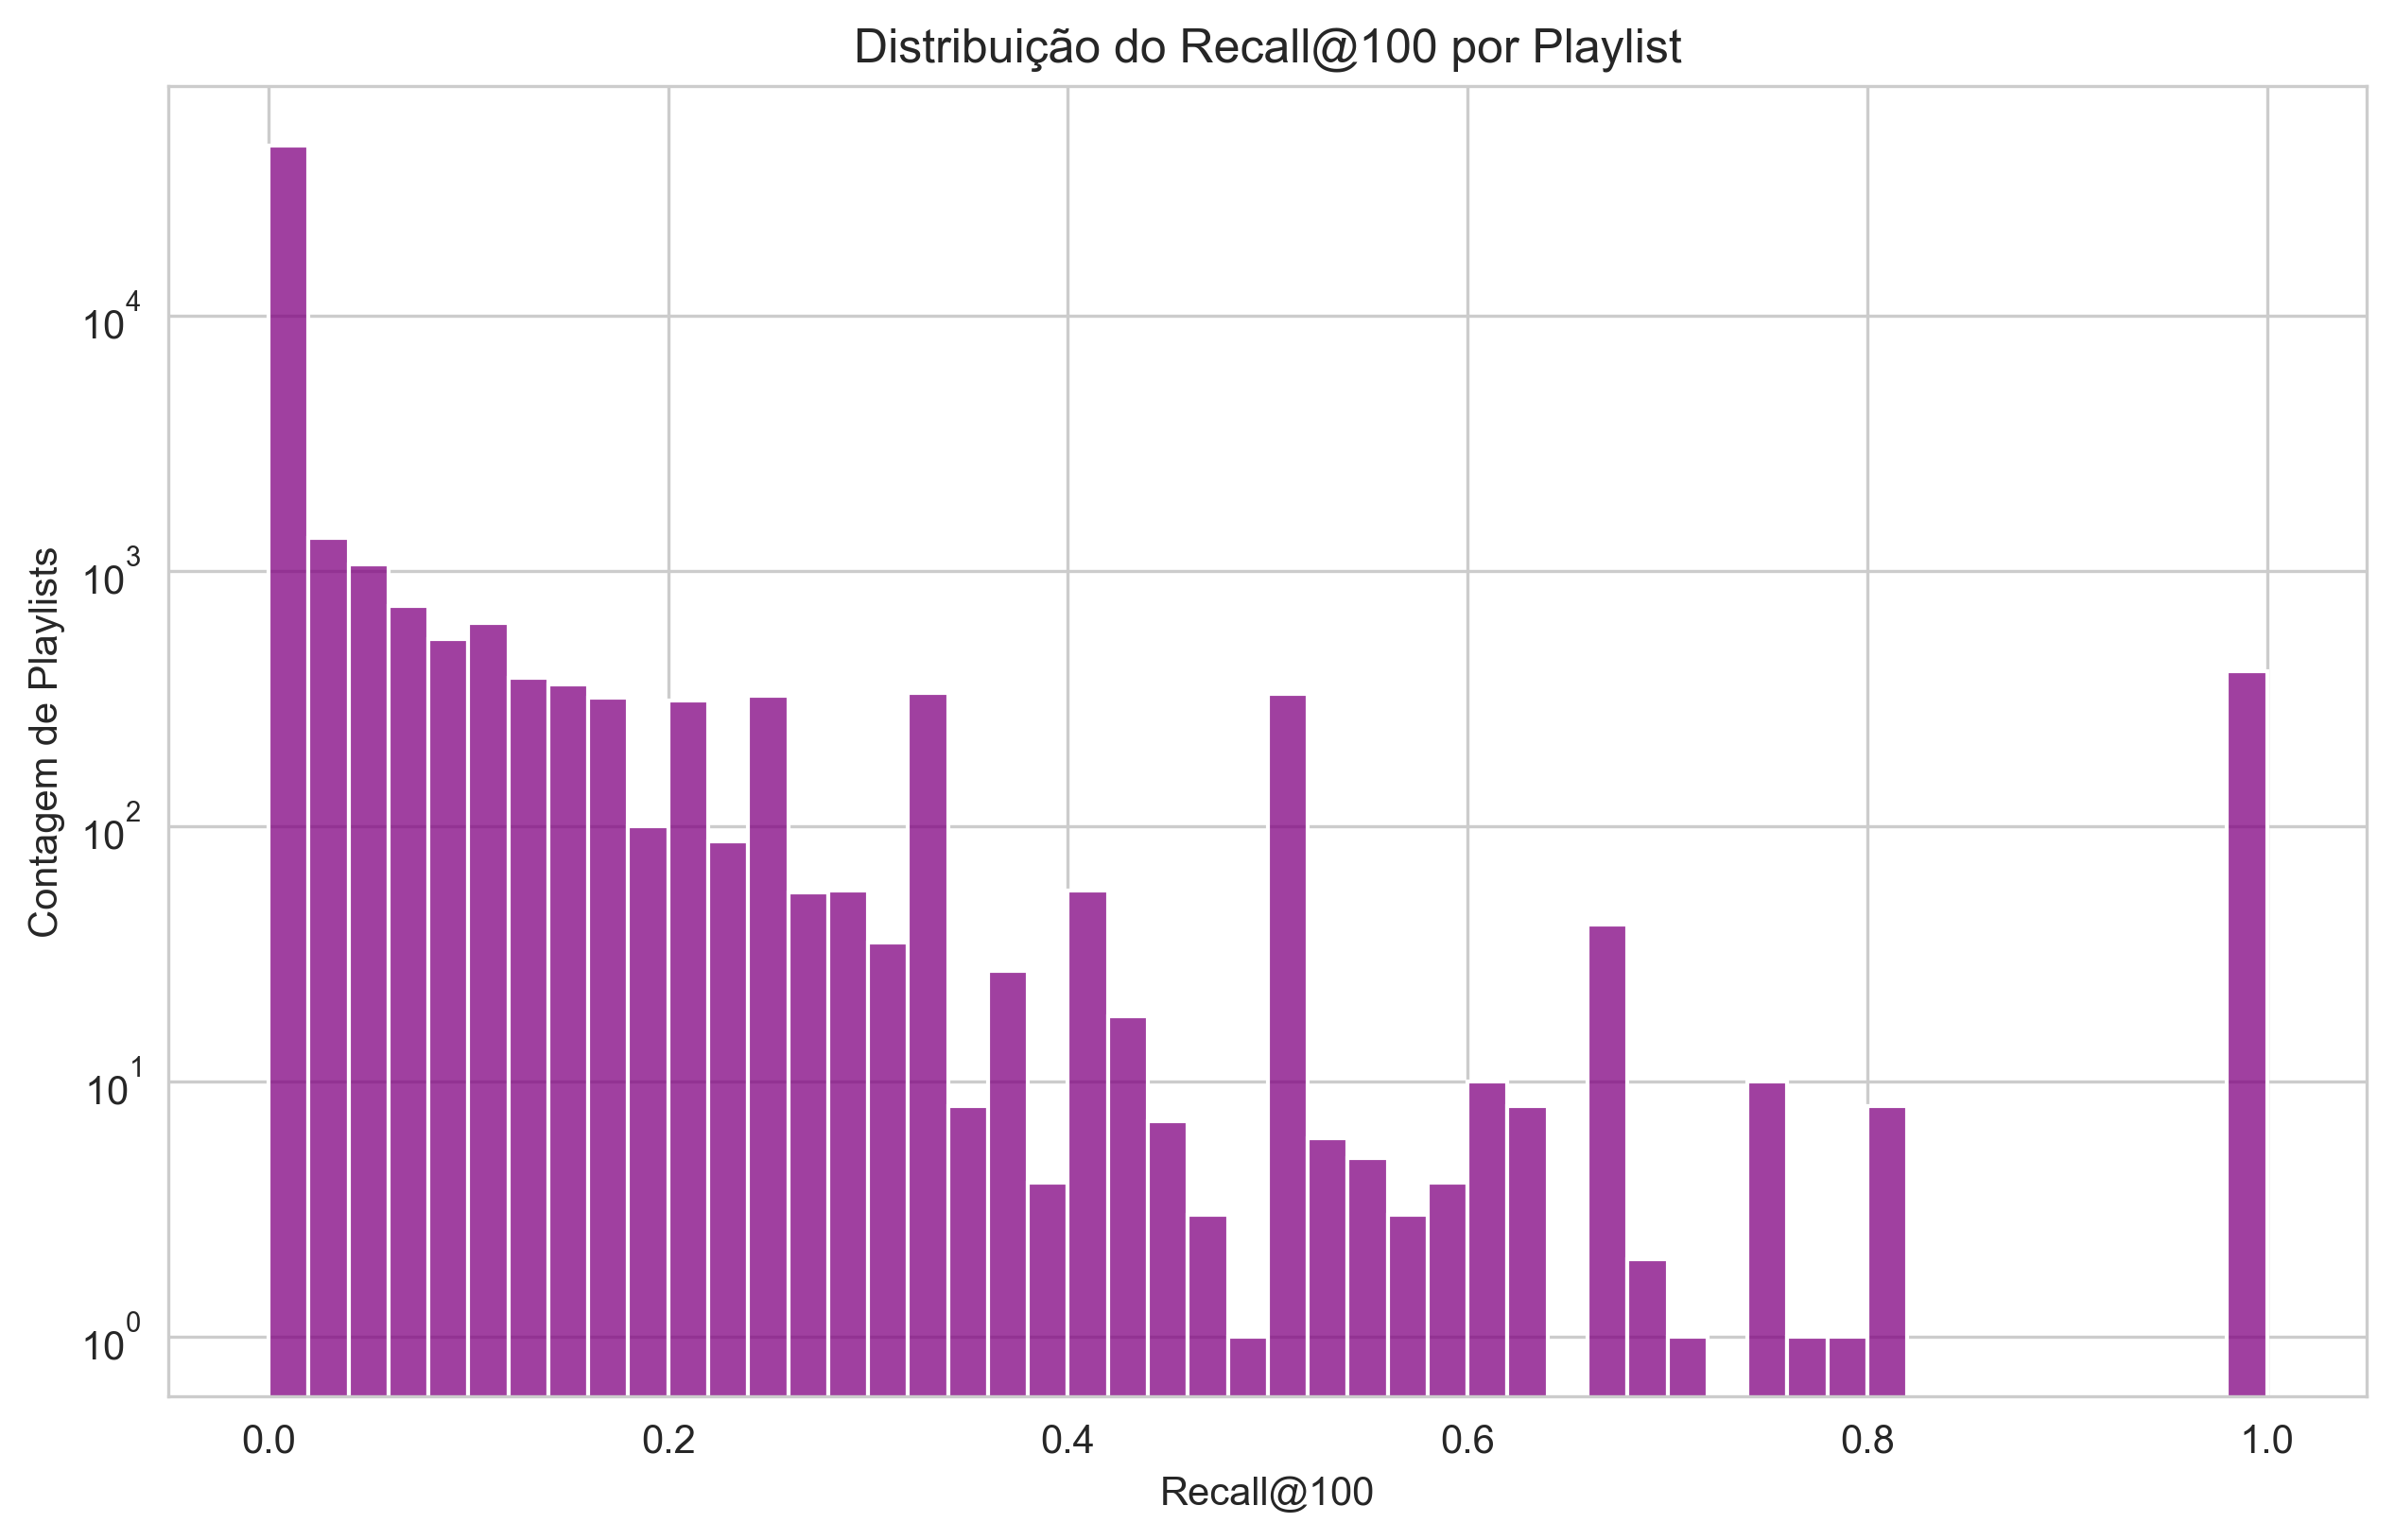

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# df_results é o DataFrame que saiu do evaluator
plt.figure(figsize=(10, 6))
sns.histplot(df_results["Recall@100"], bins=50, kde=False, color="purple")
plt.title("Distribuição do Recall@100 por Playlist")
plt.xlabel("Recall@100")
plt.ylabel("Contagem de Playlists")
plt.yscale("log") # Escala Log para ver os pequenos grupos de sucesso
plt.show()

In [ ]:
class BatchColdStartEvaluator:
    def __init__(self, Z_train, train_map, Z_new, uris_new):
        """
        Versão OTIMIZADA (Vetorizada) do avaliador.
        """
        self.Z_train = Z_train
        self.train_map = train_map
        self.Z_new = Z_new
        self.uris_new = uris_new
        
    def get_playlist_embedding(self, tracks_uris):
        # Pega índices das músicas do histórico presentes no treino
        indices = [self.train_map[u] for u in tracks_uris if u in self.train_map]
        
        if not indices:
            return None
            
        # Busca vetores
        vectors = self.Z_train[indices]
        
        # Média (Centróide)
        p_vec = np.mean(vectors, axis=0)
        
        # Normalização L2
        norm = np.linalg.norm(p_vec) + 1e-10
        return p_vec / norm

    def compute_metrics_batch(self, pids_list, hist_dict, target_dict, k_list=[20, 50, 100]):
        """
        Processa um lote de playlists de uma vez (Vetorizado).
        """
        p_matrix = []
        valid_batch_pids = []
        
        # 1. Montar Matriz de Playlists
        for pid in pids_list:
            p_vec = self.get_playlist_embedding(hist_dict[pid])
            if p_vec is not None:
                p_matrix.append(p_vec)
                valid_batch_pids.append(pid)
        
        if not p_matrix:
            return []

        # Matriz P: [Batch_Size, Dim]
        P = np.array(p_matrix) 
        
        # 2. Recomendação em Massa (Playlist x Todas as Músicas Novas)
        scores = P @ self.Z_new.T 
        
        results = []
        max_k = max(k_list)
        
        # 3. Métricas
        for i, pid in enumerate(valid_batch_pids):
            row_scores = scores[i]
            true_items = target_dict[pid]
            
            # Argpartition para pegar Top-K rápido
            top_k_indices = np.argpartition(-row_scores, max_k)[:max_k]
            sorted_indices = top_k_indices[np.argsort(-row_scores[top_k_indices])]
            
            rec_uris = self.uris_new[sorted_indices]
            
            pid_metrics = {}
            for k in k_list:
                rec_k = rec_uris[:k]
                
                # Recall
                hits = len(true_items.intersection(rec_k))
                recall = hits / len(true_items) if len(true_items) > 0 else 0.0
                
                # NDCG
                dcg = 0.0
                idcg = 0.0
                for rank, uri in enumerate(rec_k):
                    if uri in true_items:
                        dcg += 1.0 / np.log2(rank + 2)
                
                min_len = min(len(true_items), k)
                for rank in range(min_len):
                    idcg += 1.0 / np.log2(rank + 2)
                
                ndcg = dcg / idcg if idcg > 0 else 0.0
                
                pid_metrics[f"Recall@{k}"] = recall
                pid_metrics[f"NDCG@{k}"] = ndcg
            
            results.append(pid_metrics)
            
        return results

In [ ]:
# ==============================================================================
# CÉLULA FINAL: BASELINE (AUDIO-ONLY) vs GNN
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 1. CONFIGURAR BASELINE ACÚSTICO (O "Strong Baseline")
# Usamos apenas features físicas, sem gênero, para provar que a GNN aprende contexto.
AUDIO_COLS = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

print(f"Configurando Baseline Acústico...")
print(f"   Features Selecionadas: {len(AUDIO_COLS)} (Sem Gênero)")

# 2. CARREGAR DADOS BRUTOS (Usando caminhos dinâmicos P e F)
# Função local rápida para carregar apenas o necessário
def load_audio_features(path, cols):
    df = pd.read_parquet(path)
    # Padronizar coluna de ID
    if "track_uri" not in df.columns and "id" in df.columns:
        df = df.rename(columns={"id": "track_uri"})
    
    # Extrair apenas colunas de áudio
    # fillna(0) para robustez
    X = df[cols].fillna(0).to_numpy().astype("float32")
    uris = df["track_uri"].to_numpy()
    return X, uris

print("Carregando dados para Baseline...")
X_train_raw, uris_train_raw = load_audio_features(P['processed'] / F['train_features'], AUDIO_COLS)
X_test_raw, uris_test_raw   = load_audio_features(P['processed'] / F['test_features'], AUDIO_COLS)

# 3. NORMALIZAÇÃO (Vital para Baseline de Cosseno)
print("⚖️ Normalizando (StandardScaler + L2 Unitary)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# L2 Norm (para que produto escalar == cosseno)
norms_train = np.linalg.norm(X_train_scaled, axis=1, keepdims=True) + 1e-10
X_train_norm = X_train_scaled / norms_train

norms_test = np.linalg.norm(X_test_scaled, axis=1, keepdims=True) + 1e-10
X_test_norm = X_test_scaled / norms_test

# Mapa de treino para o Avaliador
train_map_raw = {u: i for i, u in enumerate(uris_train_raw)}

# 4. EXECUTAR AVALIAÇÃO DO BASELINE
print("Iniciando Avaliação do Baseline em Batch...")
baseline_evaluator = BatchColdStartEvaluator(
    Z_train=X_train_norm,
    train_map=train_map_raw,
    Z_new=X_test_norm,
    uris_new=uris_test_raw
)

BATCH_SIZE = 1000
K_VALUES = [20, 50, 100]
all_metrics_baseline = []

for i in tqdm(range(0, len(valid_pids), BATCH_SIZE)):
    batch_pids = valid_pids[i : i + BATCH_SIZE]
    batch_res = baseline_evaluator.compute_metrics_batch(
        batch_pids, hist_by_pid, target_by_pid, K_VALUES
    )
    all_metrics_baseline.extend(batch_res)

# 5. RESULTADOS E UPLIFT
df_base = pd.DataFrame(all_metrics_baseline)

print("\n" + "="*50)
print("RESULTADOS BASELINE (RAW AUDIO)")
print("="*50)
print(df_base.mean())

print("\n" + "="*50)
print("COMPARAÇÃO FINAL: GNN vs BASELINE")
print("="*50)

if 'df_results' in locals():
    # Métricas da GNN (que calculamos nas células anteriores)
    recall_gnn = df_results["Recall@100"].mean()
    ndcg_gnn = df_results["NDCG@100"].mean()
    
    # Métricas do Baseline
    recall_base = df_base["Recall@100"].mean()
    ndcg_base = df_base["NDCG@100"].mean()
    
    # Cálculo do Uplift
    uplift_recall = (recall_gnn - recall_base) / recall_base * 100 if recall_base > 0 else 0
    uplift_ndcg = (ndcg_gnn - ndcg_base) / ndcg_base * 100 if ndcg_base > 0 else 0

    print(f"{'Métrica':<15} | {'Baseline':<10} | {'GNN':<10} | {'Uplift':<10}")
    print("-" * 55)
    print(f"{'Recall@100':<15} | {recall_base:.4f}     | {recall_gnn:.4f}     | {uplift_recall:+.2f}%")
    print(f"{'NDCG@100':<15} | {ndcg_base:.4f}     | {ndcg_gnn:.4f}     | {uplift_ndcg:+.2f}%")

Configurando Baseline Acústico...
   Features Selecionadas: 9 (Sem Gênero)
Carregando dados para Baseline...
⚖️ Normalizando (StandardScaler + L2 Unitary)...
Iniciando Avaliação do Baseline em Batch...


100%|██████████| 55/55 [00:38<00:00,  1.43it/s]



RESULTADOS BASELINE (RAW AUDIO)
Recall@20     0.003077
NDCG@20       0.002560
Recall@50     0.006922
NDCG@50       0.003713
Recall@100    0.012473
NDCG@100      0.005422
dtype: float64

COMPARAÇÃO FINAL: GNN vs BASELINE
Métrica         | Baseline   | GNN (Ours) | Uplift    
-------------------------------------------------------
Recall@100      | 0.0125     | 0.0266     | +113.10%
NDCG@100        | 0.0054     | 0.0132     | +143.49%


In [11]:
# ==============================================================================
# SALVAMENTO DAS MÉTRICAS DETALHADAS
# ==============================================================================

# 1. Definir diretório de destino (config.yaml -> paths -> metrics)
# Se não estiver definido no YAML, usa o padrão reports/metrics
save_dir = P.get('metrics', BASE_DIR / "reports/metrics")

# Garantir que a pasta existe
save_dir.mkdir(parents=True, exist_ok=True)

# 2. Definir nome do arquivo
filename = "cold_start_metrics_per_playlist.parquet"
save_path = save_dir / filename

# 3. Salvar
print(f"💾 Salvando métricas detalhadas por playlist...")
df_results.to_parquet(save_path, index=False)

print(f"Arquivo salvo com sucesso em:\n   {save_path}")

💾 Salvando métricas detalhadas por playlist...
Arquivo salvo com sucesso em:
   /Users/lucasborges/Downloads/TCC/reports/metrics/cold_start_metrics_per_playlist.parquet
